In [30]:
import numpy as np
from sklearn.metrics import calinski_harabasz_score, silhouette_score, pairwise_distances_argmin_min
from scipy.spatial.distance import cdist


In [28]:
class BasicDE:
    def __init__(self, data, n_clusters=3, pop_size=10, F=0.5, Cr=0.9, generations=100):
        self.data = data
        self.n_clusters = n_clusters
        self.dim = data.shape[1]
        self.pop_size = pop_size
        self.F = F
        self.Cr = Cr
        self.generations = generations

        self.bounds = (np.min(data, axis=0), np.max(data, axis=0))
        self.population = self._init_population()

    def _init_population(self):
        min_bounds, max_bounds = self.bounds
        return np.random.rand(self.pop_size, self.n_clusters, self.dim) * (max_bounds - min_bounds) + min_bounds
    

    def evaluate_fitness(self, centers):
        dists = cdist(self.data, centers)
        labels = np.argmin(dists, axis=1)
        if len(np.unique(labels)) < 2:
            return -np.inf
        return calinski_harabasz_score(self.data, labels)

    def mutate(self, a, b, c):
        return a + self.F * (b - c)


    def crossover(self, target, mutant):
        cross_points = np.random.rand(*target.shape) < self.Cr
        return np.where(cross_points, mutant, target)


    def evolve(self):
        best_solution = None
        best_score = -np.inf
        best_labels = None

        for gen in range(self.generations):
            new_population = []
            for i in range(self.pop_size):
                idxs = [idx for idx in range(self.pop_size) if idx != i]
                a, b, c = self.population[np.random.choice(idxs, 3, replace=False)]

                mutant = self.mutate(a, b, c)
                mutant = np.clip(mutant, *self.bounds)

                trial = self.crossover(self.population[i], mutant)

                # Selection
                score_trial = self.evaluate_fitness(trial)
                score_target = self.evaluate_fitness(self.population[i])

                if score_trial > score_target:
                    new_population.append(trial)
                    if score_trial > best_score:
                        best_score = score_trial
                        best_solution = trial
                        dists = cdist(self.data, trial)
                        best_labels = np.argmin(dists, axis=1)
                else:
                    new_population.append(self.population[i])
            self.population = np.array(new_population)

        return best_solution, best_labels, best_score

# First dataset

In [18]:
import pandas as pd

auto_data_train = pd.read_csv('train_processed_data.csv')
display("Training set", auto_data_train.head())

'Training set'

,Age,Work_Experience,Family_Size,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
0,-1.284623,-0.499892,0.757947,1,0,0,5,2,3,3
1,-0.327151,0.537954,0.096095,0,1,1,2,0,3,0
2,1.408268,-0.499892,-1.227610,0,1,1,2,2,5,1
3,1.408268,-0.805141,-0.565758,1,1,1,7,1,5,1
4,-0.207467,1.453700,2.081652,0,1,1,3,1,5,0


In [19]:
import warnings
# Silence warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [20]:
X = auto_data_train.iloc[:, :-1]
X = X.to_numpy()
y_true = auto_data_train.iloc[:, -1] 

# Second dataset

In [22]:
X2 = pd.read_csv('processed_data.csv')
display("Training set", X2.head())
display(X2.info())

'Training set'

,Age,Annual Income (k$),Spending Score (1-100),Gender
0,-1.424569,-1.738999,-0.434801,1
1,-1.281035,-1.738999,1.195704,1
2,-1.352802,-1.700830,-1.715913,0
3,-1.137502,-1.700830,1.040418,0
4,-0.563369,-1.662660,-0.395980,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
 3   Gender                  200 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 6.4 KB


None

In [49]:
X2 = X2.to_numpy()

In [ ]:
def run_30_evolutions(X, n_clusters=3):
    calinski_scores = []
    silhouette_scores = []
    inertias = []

    for seed in range(1, 31):
        np.random.seed(seed)

        model = BasicDE(X, n_clusters=n_clusters)
        centers, labels, score = model.evolve()

        if len(np.unique(labels)) < 2:
            print(f"Seed {seed}: only one cluster detected, skipping...")
            continue

        inertia = np.sum((X - centers[labels]) ** 2)
        sil_score = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)

        calinski_scores.append(ch_score)
        silhouette_scores.append(sil_score)
        inertias.append(inertia)

        print(f"Seed {seed:2d} | CH: {ch_score:.2f} | Inertia: {inertia:.2f} | Silhouette: {sil_score:.2f}")

    # Compute averages
    avg_ch = np.mean(calinski_scores)
    avg_inertia = np.mean(inertias)
    avg_sil = np.mean(silhouette_scores)

    print("\n=== AVERAGE RESULTS OVER 30 RUNS ===")
    print(f"Avg Calinski-Harabasz: {avg_ch:.2f}")
    print(f"Avg Inertia:           {avg_inertia:.2f}")
    print(f"Avg Silhouette Score:  {avg_sil:.2f}")

    # Return all lists and averages
    return {
        "calinski_harabasz": calinski_scores,
        "silhouette": silhouette_scores,
        "inertia": inertias,
        "avg_calinski_harabasz": avg_ch,
        "avg_silhouette": avg_sil,
        "avg_inertia": avg_inertia
    }


In [40]:
results = run_30_evolutions(X, n_clusters=3)

Seed  1 | CH: 3667.33 | Inertia: 121685.57 | Silhouette: 0.27
Seed  2 | CH: 3650.74 | Inertia: 152969.06 | Silhouette: 0.27
Seed  3 | CH: 3654.92 | Inertia: 155555.86 | Silhouette: 0.27
Seed  4 | CH: 3666.32 | Inertia: 163364.73 | Silhouette: 0.27
Seed  5 | CH: 3585.71 | Inertia: 154988.06 | Silhouette: 0.27
Seed  6 | CH: 3641.39 | Inertia: 131256.54 | Silhouette: 0.28
Seed  7 | CH: 3534.46 | Inertia: 198822.89 | Silhouette: 0.26
Seed  8 | CH: 3641.03 | Inertia: 85708.26 | Silhouette: 0.28
Seed  9 | CH: 3669.63 | Inertia: 72305.23 | Silhouette: 0.27
Seed 10 | CH: 3656.04 | Inertia: 207449.30 | Silhouette: 0.27
Seed 11 | CH: 5148.74 | Inertia: 149701.35 | Silhouette: 0.34
Seed 12 | CH: 3659.77 | Inertia: 168312.81 | Silhouette: 0.27
Seed 13 | CH: 3612.31 | Inertia: 303294.03 | Silhouette: 0.27
Seed 14 | CH: 3664.74 | Inertia: 115574.39 | Silhouette: 0.27
Seed 15 | CH: 3646.66 | Inertia: 120148.86 | Silhouette: 0.27
Seed 16 | CH: 3621.82 | Inertia: 75685.23 | Silhouette: 0.28
Seed 17 | C

In [33]:
### 30 Runs with Metrics + Composite Score
def run_30_evolutions_with_composite(X, n_clusters=3):
    results = []

    for seed in range(1, 31):
        np.random.seed(seed)

        model = BasicDE(X, n_clusters=n_clusters)
        centers, labels, score = model.evolve()

        if len(np.unique(labels)) < 2:
            print(f"Seed {seed:2d}: only one cluster detected, skipping...")
            results.append({'run': seed, 'clusters': n_clusters, 'inertia': np.nan,
                            'silhouette': np.nan, 'calinski_harabasz': np.nan})
            continue

        inertia = np.sum((X - centers[labels]) ** 2)
        sil_score = silhouette_score(X, labels)
        ch_score = calinski_harabasz_score(X, labels)

        results.append({
            'run': seed,
            'clusters': n_clusters,
            'inertia': inertia,
            'silhouette': sil_score,
            'calinski_harabasz': ch_score
        })

        print(f"Seed {seed:2d} | CH: {ch_score:.2f} | Inertia: {inertia:.2f} | Silhouette: {sil_score:.2f}")

    df = pd.DataFrame(results)

    # Drop runs with NaNs due to single-cluster issue
    df.dropna(inplace=True)

    # Scale & compute composite score
    df_scaled = df.copy()
    scaler = MinMaxScaler()

    df_scaled[['silhouette', 'calinski_harabasz']] = scaler.fit_transform(
        df[['silhouette', 'calinski_harabasz']]
    )

    df_scaled['inertia'] = 1 - scaler.fit_transform(df[['inertia']])

    df_scaled['composite_score'] = (
        0.4 * df_scaled['inertia'] +
        0.2 * df_scaled['silhouette'] +
        0.4 * df_scaled['calinski_harabasz']
    )

    print("\n=== AVERAGE METRICS ===")
    print(df[['inertia', 'silhouette', 'calinski_harabasz']].mean())

    print("\n=== BEST COMPOSITE SCORE ===")
    print(df_scaled[df_scaled['composite_score'] == df_scaled['composite_score'].max()])

    return df_scaled



In [ ]:
df_results = run_30_evolutions_with_composite(X)

Seed  1 | CH: 3667.33 | Inertia: 121685.57 | Silhouette: 0.27
Seed  2 | CH: 3650.74 | Inertia: 152969.06 | Silhouette: 0.27
Seed  3 | CH: 3654.92 | Inertia: 155555.86 | Silhouette: 0.27
Seed  4 | CH: 3666.32 | Inertia: 163364.73 | Silhouette: 0.27
Seed  5 | CH: 3585.71 | Inertia: 154988.06 | Silhouette: 0.27
Seed  6 | CH: 3641.39 | Inertia: 131256.54 | Silhouette: 0.28
Seed  7 | CH: 3534.46 | Inertia: 198822.89 | Silhouette: 0.26
Seed  8 | CH: 3641.03 | Inertia: 85708.26 | Silhouette: 0.28
Seed  9 | CH: 3669.63 | Inertia: 72305.23 | Silhouette: 0.27
Seed 10 | CH: 3656.04 | Inertia: 207449.30 | Silhouette: 0.27
Seed 11 | CH: 5148.74 | Inertia: 149701.35 | Silhouette: 0.34
Seed 12 | CH: 3659.77 | Inertia: 168312.81 | Silhouette: 0.27
Seed 13 | CH: 3612.31 | Inertia: 303294.03 | Silhouette: 0.27
Seed 14 | CH: 3664.74 | Inertia: 115574.39 | Silhouette: 0.27
Seed 15 | CH: 3646.66 | Inertia: 120148.86 | Silhouette: 0.27
Seed 16 | CH: 3621.82 | Inertia: 75685.23 | Silhouette: 0.28
Seed 17 | C

In [43]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_clusters(X, labels, centers=None, method='pca', title='Cluster Visualization'):
    """
    Visualize high-dimensional data in 2D using PCA or t-SNE.

    Parameters:
    - X: original high-dimensional data
    - labels: predicted cluster labels
    - centers: cluster centers (optional)
    - method: 'pca' or 'tsne'
    - title: plot title
    """
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, perplexity=30, random_state=42)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    X_reduced = reducer.fit_transform(X)
    centers_reduced = reducer.transform(centers) if centers is not None else None

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=30, alpha=0.7, label='Data Points')
    
    if centers_reduced is not None:
        plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1], c='red', marker='X', s=200, label='Centers')
    
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


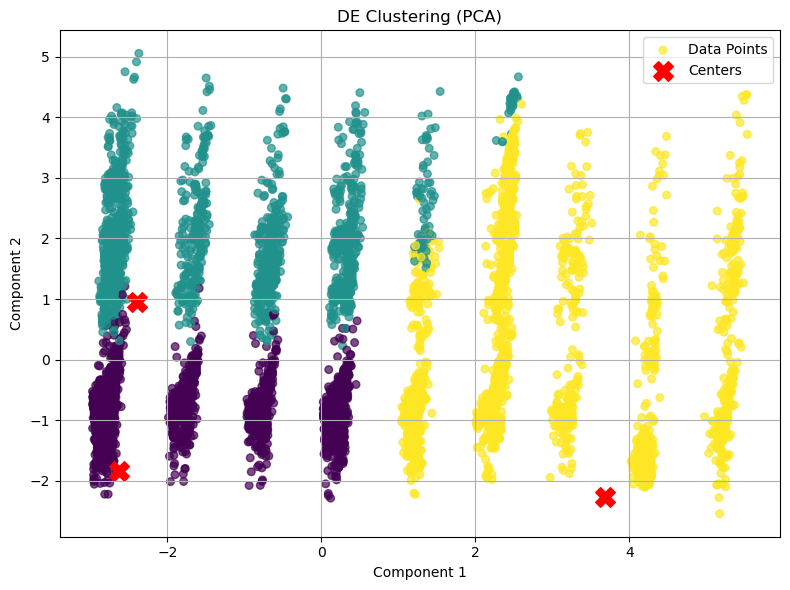

In [ ]:
# Run one clustering model for visualization
np.random.seed(10)
model = BasicDE(X, n_clusters=3)
centers, labels, _ = model.evolve()

plot_clusters(X, labels, centers, method='pca', title='DE Clustering (PCA)')


---
---
---

In [50]:
results = run_30_evolutions(X2, n_clusters=3)

Seed  1 | CH: 86.18 | Inertia: 738.94 | Silhouette: 0.31
Seed  2 | CH: 95.16 | Inertia: 790.97 | Silhouette: 0.30
Seed  3 | CH: 95.16 | Inertia: 1524.09 | Silhouette: 0.30
Seed  4 | CH: 86.44 | Inertia: 658.07 | Silhouette: 0.31
Seed  5 | CH: 86.37 | Inertia: 751.09 | Silhouette: 0.31
Seed  6 | CH: 86.32 | Inertia: 809.35 | Silhouette: 0.31
Seed  7 | CH: 86.09 | Inertia: 631.37 | Silhouette: 0.31
Seed  8 | CH: 86.12 | Inertia: 1275.90 | Silhouette: 0.31
Seed  9 | CH: 87.18 | Inertia: 615.70 | Silhouette: 0.32
Seed 10 | CH: 86.28 | Inertia: 603.99 | Silhouette: 0.31
Seed 11 | CH: 87.18 | Inertia: 533.94 | Silhouette: 0.32
Seed 12 | CH: 86.37 | Inertia: 422.54 | Silhouette: 0.31
Seed 13 | CH: 87.19 | Inertia: 558.29 | Silhouette: 0.31
Seed 14 | CH: 95.16 | Inertia: 978.38 | Silhouette: 0.30
Seed 15 | CH: 87.19 | Inertia: 501.35 | Silhouette: 0.31
Seed 16 | CH: 85.86 | Inertia: 829.07 | Silhouette: 0.31
Seed 17 | CH: 87.19 | Inertia: 659.11 | Silhouette: 0.31
Seed 18 | CH: 95.16 | Inertia

In [52]:
df_results2 = run_30_evolutions_with_composite(X2)

Seed  1 | CH: 86.18 | Inertia: 738.94 | Silhouette: 0.31
Seed  2 | CH: 95.16 | Inertia: 790.97 | Silhouette: 0.30
Seed  3 | CH: 95.16 | Inertia: 1524.09 | Silhouette: 0.30
Seed  4 | CH: 86.44 | Inertia: 658.07 | Silhouette: 0.31
Seed  5 | CH: 86.37 | Inertia: 751.09 | Silhouette: 0.31
Seed  6 | CH: 86.32 | Inertia: 809.35 | Silhouette: 0.31
Seed  7 | CH: 86.09 | Inertia: 631.37 | Silhouette: 0.31
Seed  8 | CH: 86.12 | Inertia: 1275.90 | Silhouette: 0.31
Seed  9 | CH: 87.18 | Inertia: 615.70 | Silhouette: 0.32
Seed 10 | CH: 86.28 | Inertia: 603.99 | Silhouette: 0.31
Seed 11 | CH: 87.18 | Inertia: 533.94 | Silhouette: 0.32
Seed 12 | CH: 86.37 | Inertia: 422.54 | Silhouette: 0.31
Seed 13 | CH: 87.19 | Inertia: 558.29 | Silhouette: 0.31
Seed 14 | CH: 95.16 | Inertia: 978.38 | Silhouette: 0.30
Seed 15 | CH: 87.19 | Inertia: 501.35 | Silhouette: 0.31
Seed 16 | CH: 85.86 | Inertia: 829.07 | Silhouette: 0.31
Seed 17 | CH: 87.19 | Inertia: 659.11 | Silhouette: 0.31
Seed 18 | CH: 95.16 | Inertia

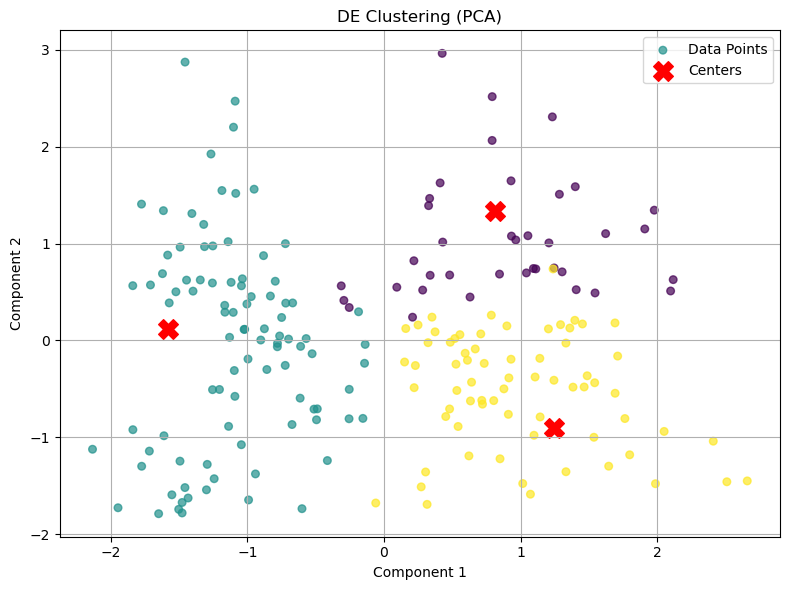

In [57]:
# Run one clustering model for visualization
np.random.seed(12)
model = BasicDE(X2, n_clusters=3)
centers, labels, _ = model.evolve()

plot_clusters(X2, labels, centers, method='pca', title='DE Clustering (PCA)')
